# Configuration de MLFlow avec tracking local

In [1]:
# pip install mlflow
import mlflow

In [2]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("modele_avancé")

<Experiment: artifact_location='mlflow-artifacts:/566106427225564143', creation_time=1729147540629, experiment_id='566106427225564143', last_update_time=1729147540629, lifecycle_stage='active', name='modele_avancé', tags={}>

# Word2Vec

In [3]:
# # utilisation dans Google collab
# print('Mounting your Google Drive...')
# from google.colab import drive
# drive.mount('/content/drive')
# print('Opening the file...')
# %cd /content/drive/My Drive/P7
# !ls

In [4]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [5]:
import multiprocessing
# Paramètres du modèle Word2Vec
w2v_size = 300        # Taille des vecteurs
w2v_window = 5        # Taille de la fenêtre contextuelle
w2v_min_count = 1     # Nombre minimum d'occurrences d'un mot pour être pris en compte
w2v_epochs = 100      # Nombre d'itérations (époques)
workers = multiprocessing.cpu_count()  # Utilisation de tous les cœurs disponibles

### Données

In [6]:
import pandas as pd

train_df = pd.read_csv("./data/train_df.csv")
train_df = train_df.iloc[:, 1:]
test_df = pd.read_csv("./data/test_df.csv")
test_df = test_df.iloc[:, 1:]

### Préparation des sentences

In [7]:
# Préparation des sentences à partir de la colonne 'preprocessed_text'
# Tokenisation de chaque phrase en séparant les mots sur les espaces
train_sentences = [sentence.split() for sentence in train_df['preprocessed_text'].astype(str)]
test_sentences = [sentence.split() for sentence in test_df['preprocessed_text'].astype(str)]

### Modèle Word2Vec

In [8]:
from gensim.models import Word2Vec
# Instanciation du modèle Word2Vec
w2v_model = Word2Vec(
    sentences=train_sentences,   # Les phrases tokenisées d'entraînement
    vector_size=w2v_size,        # Taille des vecteurs
    window=w2v_window,           # Taille de la fenêtre contextuelle
    min_count=w2v_min_count,     # Seuil d'apparition minimum d'un mot
    workers=workers,             # Nombre de threads (CPU cores) à utiliser
    sg=1                         # Utilisation de Skip-gram (si sg=0, on utilise CBOW)
)

In [9]:
# Entraînement du modèle
w2v_model.train(train_sentences, total_examples=len(train_sentences), epochs=w2v_epochs)


(2803635, 3447500)

In [10]:
# Sauvegarde du modèle après entraînement
w2v_model.save("./models/word2vec_model.model")

### Matrice d'embeddings

In [11]:
# Taille du vocabulaire (le nombre de mots uniques)
vocab_size = len(w2v_model.wv.index_to_key)

# Extraction de la matrice d'embedding
embedding_matrix = []
for word in w2v_model.wv.index_to_key:
    embedding_matrix.append(w2v_model.wv[word])

# Conversion en numpy array
import numpy as np
embedding_matrix = np.array(embedding_matrix)

# Dimensions de la matrice d'embedding : vocab_size x w2v_size
print("Matrice d'embedding de taille :", embedding_matrix.shape)

Matrice d'embedding de taille : (6006, 300)


### Modèles tests d'embedding Keras

Les essais avec un modèle simple (LSTM et dense) ont montré un sur-apprentissage important. Il faut l'optimiser avec dropout, regularisation.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Paramètres
maxlen = 40  # Longueur maximale des séquences de mots
vocab_size = len(w2v_model.wv.index_to_key)  # Taille du vocabulaire
print("Taille du vocabulaire dans W2Vec :", vocab_size)

Taille du vocabulaire dans W2Vec : 6006


In [13]:
# Génération de données d'entraînement fictives (100 échantillons, chaque séquence de longueur maxlen pour la construction des modèles
fictive_data = np.random.randint(0, vocab_size, size=(100, maxlen))
fictive_labels = np.random.randint(0, 2, size=(100,))

In [14]:
# Instanciation du modèle séquentiel 1
model_W2v_1 = Sequential()

# Ajout de la couche d'embedding avec la matrice pré-entraînée
model_W2v_1.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Utilisation de la matrice d'embedding pré-entraînée
    trainable=False             # Geler les poids de l'embedding
))

# Ajout d'une couche LSTM pour capturer les relations séquentielles
model_W2v_1.add(LSTM(128))

# Ajout d'une couche de sortie (par exemple, pour de la classification binaire)
model_W2v_1.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model_W2v_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement fictif afin de visualiser le nombre de paramètres
model_W2v_1.fit(fictive_data, fictive_labels, epochs=3, batch_size=32)

# Affichage du résumé du modèle
model_W2v_1.summary()

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5094 - loss: 0.6998
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7182 - loss: 0.6589
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7292 - loss: 0.6379


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,461,133 (9.39 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 439,556 (1.68 MB)

In [15]:
# Instanciation du modèle séquentiel 2
from tensorflow.keras.regularizers import l2

# Ajout de la régularisation L2 dans la couche LSTM et la couche Dense
model_W2v_2 = Sequential()
model_W2v_2.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model_W2v_2.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la régularisation L2
model_W2v_2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du modèle
model_W2v_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement fictif afin de visualiser le nombre de paramètres
model_W2v_2.fit(fictive_data, fictive_labels, epochs=3, batch_size=32)

# Affichage du résumé du modèle
model_W2v_2.summary()

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5175 - loss: 4.4103
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5849 - loss: 3.9552
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4865 - loss: 3.5542


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,461,133 (9.39 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 439,556 (1.68 MB)

In [16]:
# Modèle 3 avec dropout

from tensorflow.keras.layers import Dropout

# Ajout de Dropout après la couche LSTM pour prévenir l'overfitting
model_W2v_3 = Sequential()
model_W2v_3.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                    trainable=False))
model_W2v_3.add(LSTM(128, kernel_regularizer=l2(0.01)))  # Ajout de la régularisation L2
model_W2v_3.add(Dropout(0.5))  # Dropout de 50% des neurones
model_W2v_3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))  # Ajout L2 dans la couche Dense

# Compilation du modèle
model_W2v_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement fictif afin de visualiser le nombre de paramètres
model_W2v_3.fit(fictive_data, fictive_labels, epochs=3, batch_size=32)

# Affichage du résumé du modèle
model_W2v_3.summary()

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4428 - loss: 4.4532
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5038 - loss: 4.0070
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6668 - loss: 3.5838


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,461,133 (9.39 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 439,556 (1.68 MB)

In [17]:
# Réduction du nombre d'unités dans la couche LSTM
model_W2v_4 = Sequential()
model_W2v_4.add(Embedding(input_dim=vocab_size, output_dim=w2v_size, weights=[embedding_matrix],
                # input_length=maxlen,
                trainable=False))
model_W2v_4.add(LSTM(64, kernel_regularizer=l2(0.01)))  # Moins d'unités LSTM
model_W2v_3.add(Dropout(0.5))  # Dropout de 50% des neurones
model_W2v_4.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compilation du modèle
model_W2v_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement fictif afin de visualiser le nombre de paramètres
model_W2v_4.fit(fictive_data, fictive_labels, epochs=3, batch_size=32)

model_W2v_4.summary()

Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4979 - loss: 3.4272
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6101 - loss: 3.1293 
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6357 - loss: 2.8834 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,082,317 (7.94 MB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 187,012 (730.52 KB)

In [18]:
# Code du modèle avec GRU, Dropout et régularisation L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Importer Adam pour ajuster le learning rate

# Paramètres de régularisation et Dropout
dropout_rate = 0.5      # Pourcentage de neurones ignorés
l2_lambda = 0.01        # Facteur de régularisation L2
learning_rate = 0.0001  # Taux d'apprentissage spécifique

# Instanciation du modèle séquentiel
model_W2v_5 = Sequential()

# 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
model_W2v_5.add(Embedding(
    input_dim=vocab_size,       # Taille du vocabulaire
    output_dim=w2v_size,        # Dimension des vecteurs d'embedding
    weights=[embedding_matrix], # Matrice d'embedding pré-entraînée
    # input_length=maxlen,        # Longueur maximale des séquences
    trainable=False             # Geler les poids de l'embedding
))

# 2. Couche GRU avec Dropout et régularisation L2
model_W2v_5.add(GRU(
    units=128,                    # Nombre d'unités GRU
    kernel_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids
    recurrent_regularizer=l2(l2_lambda),  # Régularisation L2 sur les poids récurrents
    dropout=dropout_rate,         # Dropout sur les connexions entrantes
    recurrent_dropout=dropout_rate  # Dropout sur les connexions récurrentes
))

# 3. Couche de sortie Dense avec régularisation L2
model_W2v_5.add(Dense(
    units=1,                      # Pour une tâche de classification binaire
    activation='sigmoid',          # Sigmoid pour la probabilité binaire
    kernel_regularizer=l2(l2_lambda)  # Régularisation L2 sur la couche de sortie
))

# Définir l'optimiseur Adam avec un learning rate spécifique
optimizer = Adam(learning_rate=learning_rate)

# Compilation du modèle
model_W2v_5.compile(
    optimizer=optimizer,          # Utiliser l'optimiseur Adam avec le learning rate défini
    loss='binary_crossentropy',   # Fonction de perte pour une classification binaire
    metrics=['accuracy']          # Métrique d'accuracy
)

# Entraînement fictif afin de visualiser le nombre de paramètres
model_W2v_5.fit(fictive_data, fictive_labels, epochs=3, batch_size=32)

# Affichage du résumé du modèle
model_W2v_5.summary()


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5707 - loss: 786280192.0000
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4967 - loss: 908713856.0000
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4653 - loss: 794550464.0000


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │         165,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,297,549 (8.76 MB)

 Trainable params: 165,249 (645.50 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 330,500 (1.26 MB)

In [19]:
# Liste des modèles
models = [model_W2v_1, model_W2v_2, model_W2v_3, model_W2v_4, model_W2v_5] 

### Préparation des données pour l'exécution du modèle

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Création d'un dictionnaire mot->index à partir du vocabulaire de Word2Vec
word_index = {word: i for i, word in enumerate(w2v_model.wv.index_to_key)}

# Fonction pour convertir les phrases en séquences d'index
def sentences_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        seq = [word_index.get(word, 0) for word in sentence]  # Remplacer les mots inconnus par 0
        sequences.append(seq)
    return sequences

# Conversion des phrases d'entraînement et de test en séquences d'index
train_sequences = sentences_to_sequences(train_sentences, word_index)
test_sequences = sentences_to_sequences(test_sentences, word_index)

# Padding des séquences pour qu'elles aient toutes la même longueur (maxlen)
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

# Exemple d'affichage des séquences après padding
print(train_padded[:5])


[[ 165   65  990 2556 2546  957    6  167 1161  419  867 1145   32 2684
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 406   16  750    3    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2726  838   28  101   32    4   14    5   86    5   41  101   72   90
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [2520 2594 2424  450   54  612  193 2549   19    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1 2618 2686    5  419    5   55  105  177   81    6  179  496  239
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [21]:
y_train = train_df['target'].values
y_test = test_df['target'].values

### Entrainement du modèle d'embedding

In [22]:
n_epchos = 12
batch_size = 64

In [23]:
# Entraînement du modèle 1 avec validation et sauvegarde de l'historique
history_w2v_1 = model_W2v_1.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=n_epchos,            # Nombre d'époques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4907 - loss: 0.7054 - val_accuracy: 0.5014 - val_loss: 0.6940
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5110 - loss: 0.6995 - val_accuracy: 0.4986 - val_loss: 0.6936
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4782 - loss: 0.6953 - val_accuracy: 0.4986 - val_loss: 0.6933
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4980 - loss: 0.6938 - val_accuracy: 0.4986 - val_loss: 0.6936
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5022 - loss: 0.6956 - val_accuracy: 0.4986 - val_loss: 0.6933
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4883 - loss: 0.6974 - val_accuracy: 0.4986 - val_loss: 0.6946
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4906 - loss: 0.6954 - val_accuracy: 0.4986 - val_loss: 0.6932
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4827 - loss: 0.6940 - val_accuracy: 0.4986 - v

In [24]:
# Entraînement du modèle 2 avec validation et sauvegarde de l'historique
history_w2v_2 = model_W2v_2.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=n_epchos,            # Nombre d'époques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4807 - loss: 2.4528 - val_accuracy: 0.4986 - val_loss: 1.0785
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5038 - loss: 0.9616 - val_accuracy: 0.4986 - val_loss: 0.7788
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4964 - loss: 0.7627 - val_accuracy: 0.4986 - val_loss: 0.7274
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5175 - loss: 0.7272 - val_accuracy: 0.5014 - val_loss: 0.7214
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4960 - loss: 0.7135 - val_accuracy: 0.5014 - val_loss: 0.7028
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5101 - loss: 0.7015 - val_accuracy: 0.4986 - val_loss: 0.6985
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5007 - loss: 0.7008 - val_accuracy: 0.5014 - val_loss: 0.6973
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5139 - loss: 0.6959 - val_accuracy: 0.4986 - v

In [25]:
# Entraînement du modèle 3 avec validation et sauvegarde de l'historique
history_w2v_3 = model_W2v_3.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=n_epchos,            # Nombre d'époques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5049 - loss: 6.5553 - val_accuracy: 0.4986 - val_loss: 1.5974
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4998 - loss: 4.9124 - val_accuracy: 0.4986 - val_loss: 1.2203
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4866 - loss: 4.8020 - val_accuracy: 0.4986 - val_loss: 1.0330
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5035 - loss: 4.3782 - val_accuracy: 0.4986 - val_loss: 0.9734
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4960 - loss: 4.5642 - val_accuracy: 0.4986 - val_loss: 0.8701
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4980 - loss: 4.5212 - val_accuracy: 0.4986 - val_loss: 0.9006
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5038 - loss: 4.4891 - val_accuracy: 0.4986 - val_loss: 0.8751
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4939 - loss: 4.5259 - val_accuracy: 0.4986 - v

In [26]:
# Entraînement du modèle 4 avec validation et sauvegarde de l'historique
history_w2v_4 = model_W2v_4.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=n_epchos,            # Nombre d'époques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4858 - loss: 2.1665 - val_accuracy: 0.5014 - val_loss: 1.1389
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5123 - loss: 1.0172 - val_accuracy: 0.5014 - val_loss: 0.8086
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4988 - loss: 0.7893 - val_accuracy: 0.4986 - val_loss: 0.7408
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4877 - loss: 0.7343 - val_accuracy: 0.4986 - val_loss: 0.7180
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5129 - loss: 0.7180 - val_accuracy: 0.5014 - val_loss: 0.7077
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4835 - loss: 0.7076 - val_accuracy: 0.5014 - val_loss: 0.7023
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4926 - loss: 0.7033 - val_accuracy: 0.4986 - val_loss: 0.6987
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4983 - loss: 0.6991 - val_accuracy: 0.5014 - v

In [27]:
# Entraînement du modèle 4 avec validation et sauvegarde de l'historique
history_w2v_5 = model_W2v_5.fit(
    train_padded,         # Données d'entraînement
    y_train,              # Étiquettes d'entraînement
    epochs=n_epchos,            # Nombre d'époques
    batch_size=batch_size,        # Taille des batchs
    validation_data=(test_padded, y_test),  # Validation sur les données de test
    verbose=1             # Afficher l'évolution pendant l'entraînement
)

Epoch 1/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5097 - loss: 1921541888.0000 - val_accuracy: 0.4986 - val_loss: 5.3655
Epoch 2/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4851 - loss: 1528766208.0000 - val_accuracy: 0.4986 - val_loss: 5.3612
Epoch 3/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5108 - loss: 1222182912.0000 - val_accuracy: 0.4986 - val_loss: 5.3602
Epoch 4/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5094 - loss: 1046042624.0000 - val_accuracy: 0.4986 - val_loss: 5.3592
Epoch 5/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4954 - loss: 969031424.0000 - val_accuracy: 0.4986 - val_loss: 5.3544
Epoch 6/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5050 - loss: 774727232.0000 - val_accuracy: 0.4986 - val_loss: 5.3516
Epoch 7/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5210 - loss: 714801536.0000 - val_accuracy: 0.4986 - val_loss: 5.3484
Epoch 8/12
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 

### Visualisation de l'entrainement des modèles

In [28]:
# pip install plot-keras-history
# Source: @software{Cappelletti_Plot_Keras_History_2022,
#     author = {Cappelletti, Luca},
#     doi = {10.5072/zenodo.1054923},
#     month = {4},
#     title = {{Plot Keras History}},
#     version = {1.1.36},
#     year = {2022}
# }

C:\Users\cecil\AppData\Local\Temp\ipykernel_32212\2247876459.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Ajuster les espacements


<Figure size 1000x500 with 0 Axes>

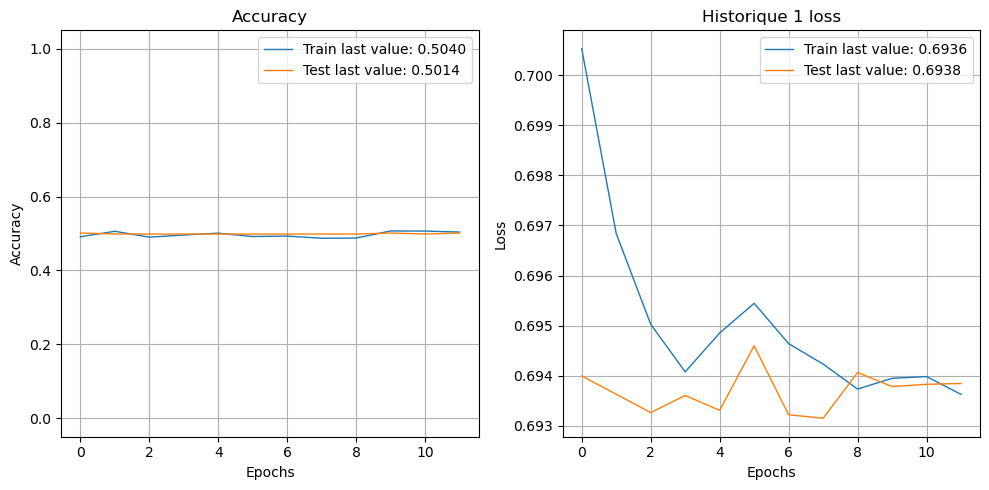

<Figure size 1000x500 with 0 Axes>

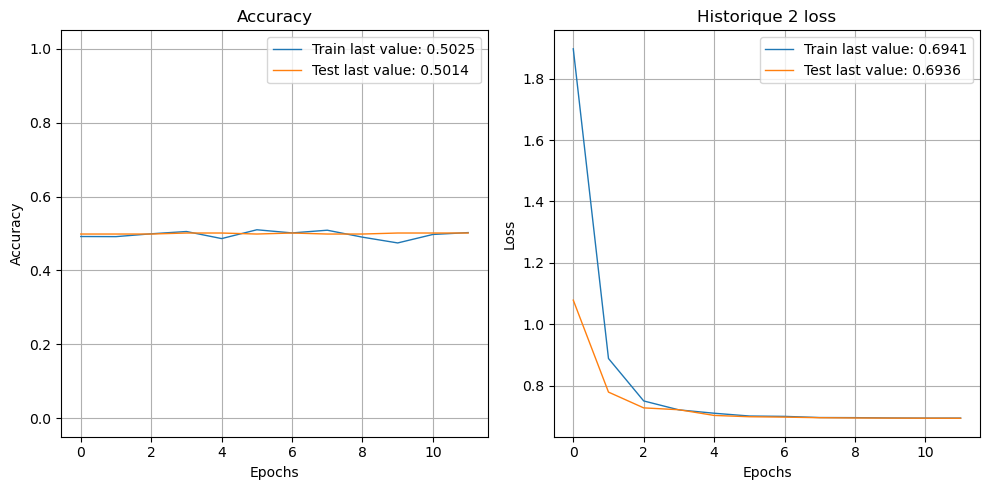

<Figure size 1000x500 with 0 Axes>

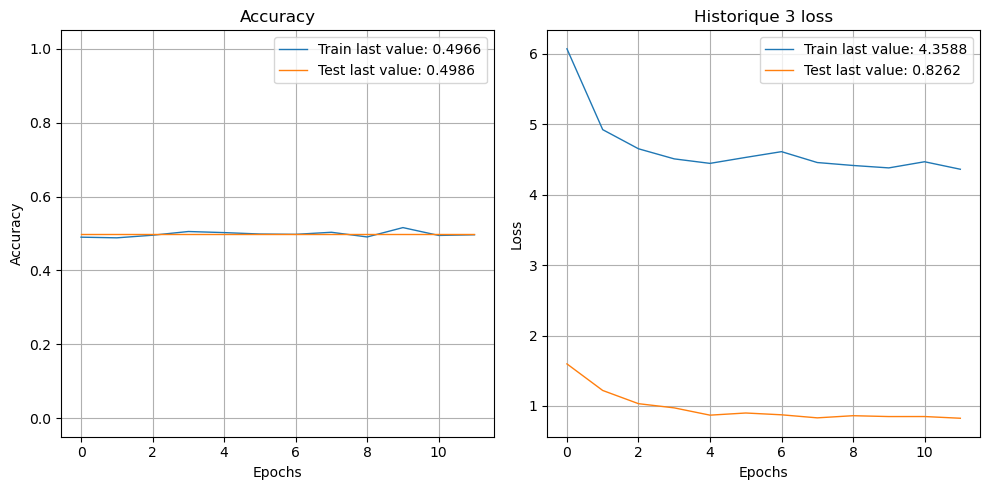

<Figure size 1000x500 with 0 Axes>

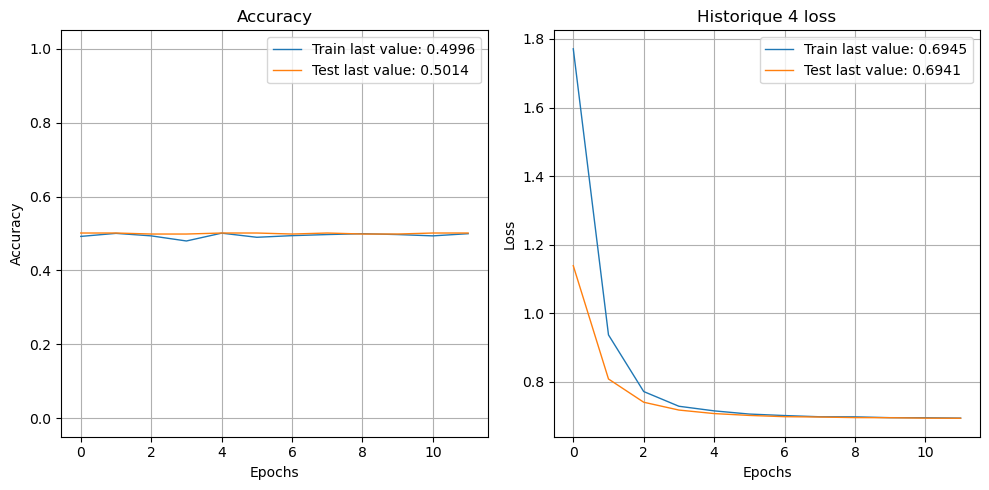

<Figure size 1000x500 with 0 Axes>

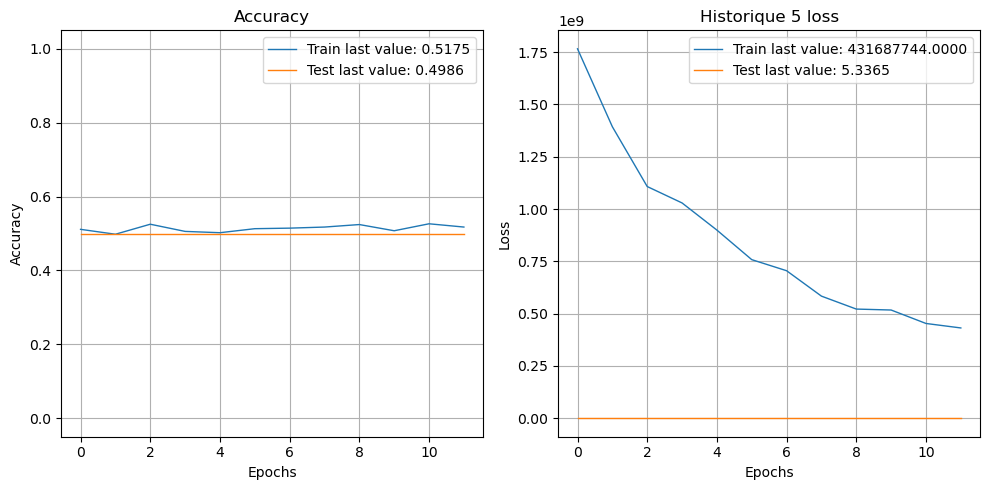

In [29]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# Supposons que tu as plusieurs historiques
histories = [history_w2v_1, history_w2v_2, history_w2v_3, history_w2v_4, history_w2v_5]  

# Afficher chaque historique dans un nouveau graphe
for i, history in enumerate(histories):
    plt.figure(figsize=(10, 5))  # Créer une nouvelle figure pour chaque historique
    plot_history(history.history)  # Afficher l'historique
    plt.title(f'Historique {i+1} loss')  # Ajouter un titre spécifique
    plt.tight_layout()  # Ajuster les espacements
    plt.show()

### Enregistrement des essais

In [30]:
# Fonction pour logger un historique d'entraînement
def log_history(history, history_index):
    for key in history.history.keys():
        for epoch, value in enumerate(history.history[key]):
            mlflow.log_metric(f"{key}_history_{history_index}", value, step=epoch)

In [31]:
# Fonction pour logger un graphe de l'historique
def log_history_plot(history, history_index):
    plt.figure(figsize=(10, 5))
    plot_history(history.history)
    plt.title(f'Historique {history_index}')
    
    # Sauvegarder l'image du graphe localement
    plot_path = f"history_plot_{history_index}.png"
    plt.savefig(plot_path)
    plt.close()  # Fermer le graphe pour ne pas l'afficher
    
    # Logger le graphe comme artefact dans MLflow
    mlflow.log_artifact(plot_path)

In [32]:
# Dictionnaire pour les tags spécifiques de chaque modèle
tags_dict = {
    "model_W2v_1": {"embedding": "Word2Vec", "layers": "LSTM128"},
    "model_W2v_2": {"embedding": "Word2Vec", "layers": "LSTM128, L2"},
    "model_W2v_3": {"embedding": "Word2Vec", "layers": "LSTM128, L2, dropout"},
    "model_W2v_4": {"embedding": "Word2Vec", "layers": "LSTM64, L2, dropout"},
    "model_W2v_5": {"embedding": "Word2Vec", "layers": "GRU, dropout, L2"},
}

In [33]:
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature

# Utilisation d'un petit lot de données réelles pour la signature
example_input = train_padded[:5]  # Les 5 premiers échantillons de train_padded

# Démarrer un seul run MLflow pour enregistrer tous les modèles
with mlflow.start_run(run_name="Entraînement de modèles tests avec Word2Vec"):

    # Boucle sur les clés du dictionnaire de tags
    for i, model_key in enumerate(tags_dict.keys()):
        # Récupérer le modèle et l'historique correspondant
        model = models[i]  # On suppose que models est une liste de modèles
        history = histories[i]  # On suppose que histories est une liste d'historiques

        # Calculer la sortie pour chaque modèle (les sorties sont différentes)
        example_output = model.predict(example_input)

        # Définir la signature pour chaque modèle en fonction de ses sorties spécifiques
        signature = infer_signature(example_input, example_output)

        # Logger le modèle avec la signature
        mlflow.keras.log_model(
            model,
            model_key,
            signature=signature
        )

        # Logger les tags
        for tag_key, tag_value in tags_dict[model_key].items():
            mlflow.set_tag(tag_key, tag_value)

        # Logger les métriques de l'historique
        log_history(history, int(model_key.split('_')[-1]))

        # Logger les graphes d'historique
        log_history_plot(history, int(model_key.split('_')[-1]))

        print(f"{model_key} enregistré avec la signature et les tags dans MLflow.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
model_W2v_1 enregistré avec la signature et les tags dans MLflow.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
model_W2v_2 enregistré avec la signature et les tags dans MLflow.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
model_W2v_3 enregistré avec la signature et les tags dans MLflow.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
model_W2v_4 enregistré avec la signature et les tags dans MLflow.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


2024/10/18 20:58:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run Entraînement de modèles tests avec Word2Vec at: http://localhost:5000/#/experiments/566106427225564143/runs/92d7328dac3c492493f44b1b7ef3ac79.
2024/10/18 20:58:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


model_W2v_5 enregistré avec la signature et les tags dans MLflow.


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [34]:
# Terminer la session MLflow
mlflow.end_run()

### Optimisation automatique du modèle d'embedding

Utilisation de <u><b>Keras tuner</b></u> pour optimiser le modèle en faisant varier:<br>
- le nombre d'unités GRU
- le taux de dropout
- la régularisation L2
- le taux d'apprentissage <br>
Par ailleurs on a introduit une couche LSTM bi-directionnelle

In [35]:
# Fonction de création du modèle pour Keras Tuner
def build_model(hp):
    model = Sequential()
    
    # 1. Couche d'embedding avec la matrice Word2Vec pré-entraînée
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],     
        output_dim=embedding_matrix.shape[1],         
        weights=[embedding_matrix],  
        # input_length=maxlen,         
        trainable=False              
    ))

    # 2. Couche LSTM bidirectionnelle avec des hyperparamètres tunables
    model.add(Bidirectional(LSTM(
        units=hp.Int('units', min_value=64, max_value=256, step=32),
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),  # Intervalle élargi
        recurrent_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log')),
        dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),  # Dropout plus élevé
        recurrent_dropout=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1),
        return_sequences=False
    )))

    # 3. Couche de sortie Dense avec régularisation L2
    model.add(Dense(
        units=1,                      
        activation='sigmoid',          
        kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-4, max_value=1e-2, sampling='log'))
    ))

    # Optimiseur Adam avec un learning rate tunable
    optimizer = Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))

    # Compilation du modèle
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [38]:
# pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [39]:
import os
import shutil
# Supprimer le répertoire s'il existe déjà (pour refaire une mise au point de paramètres à chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner après suppression
tuner_W2v = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',  # Répertoire standard mais il sera recréé
    project_name='lstm_bidirectional_tuning_W2v'
)

In [44]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparamètres
tuner_W2v.search(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

# Récupération des meilleurs hyperparamètres
best_hps_W2v = tuner_W2v.get_best_hyperparameters(num_trials=1)[0]

# Entraîner le meilleur modèle avec ces hyperparamètres
best_model_W2v = tuner_W2v.hypermodel.build(best_hps_W2v)
history_W2v = best_model_W2v.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

Trial 30 Complete [00h 01m 44s]
val_loss: 0.9946544170379639

Best val_loss So Far: 0.6104708313941956
Total elapsed time: 00h 11m 18s
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5764 - loss: 1.5184 - val_accuracy: 0.6291 - val_loss: 0.7331
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6514 - loss: 0.7151 - val_accuracy: 0.6490 - val_loss: 0.6774
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6531 - loss: 0.6815 - val_accuracy: 0.6676 - val_loss: 0.6524
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6557 - loss: 0.6652 - val_accuracy: 0.6037 - val_loss: 0.7149
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6339 - loss: 0.6901 - val_accuracy: 0.6538 - val_loss: 0.6515
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6607 - loss: 0.6593 - val_accuracy: 0.6923 - val_loss: 0.6342
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6492 - loss: 0.6654 - va

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

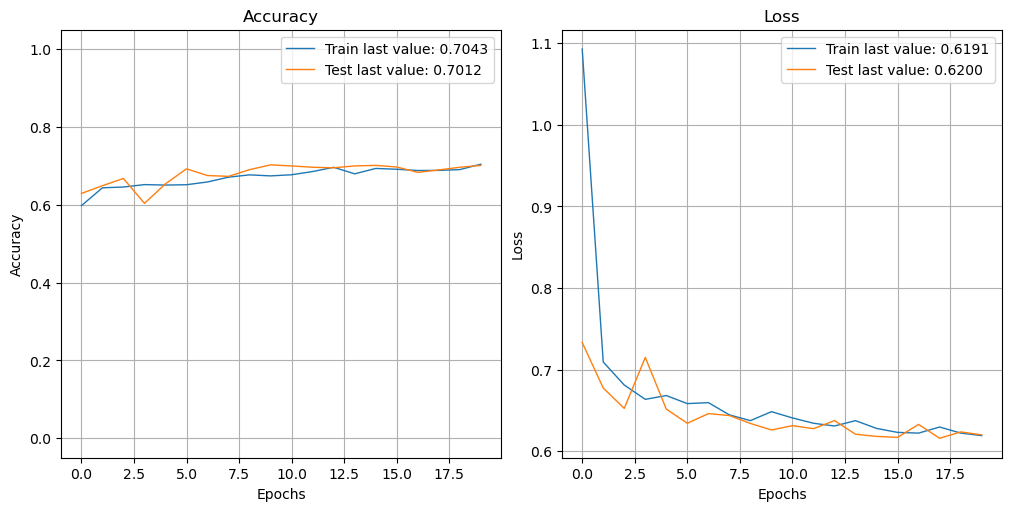

In [45]:
# Plot de l'historique de l'entraînement
plot_history(history_W2v.history)

In [46]:
# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :")
print(f" - Units dans LSTM : {best_hps_W2v.get('units')}")
print(f" - Lambda de régularisation L2 : {best_hps_W2v.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_W2v.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_W2v.get('learning_rate')}")

# Construire le meilleur modèle avec les meilleurs hyperparamètres
# Spécifier l'input_shape correspondant à tes données (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le modèle explicitement avec la taille d'entrée
best_model_W2v.build(input_shape=(None, *input_shape))  # None correspond à la taille du batch

# Affichage du résumé du modèle
best_model_W2v.summary()

Meilleurs hyperparamètres trouvés :
 - Units dans LSTM : 64
 - Lambda de régularisation L2 : 0.002830550401329462
 - Dropout rate : 0.4
 - Learning rate : 0.0029686845449792697


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 300)             │       1,801,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,362,829 (9.01 MB)

 Trainable params: 187,009 (730.50 KB)

 Non-trainable params: 1,801,800 (6.87 MB)

 Optimizer params: 374,020 (1.43 MB)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


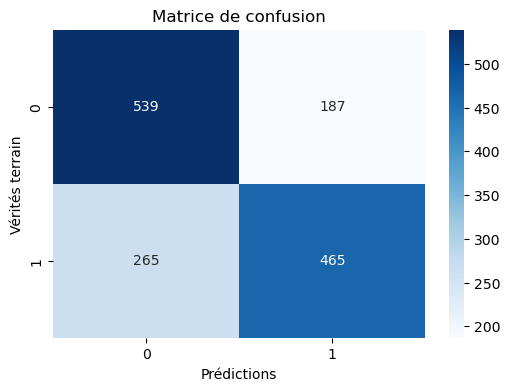

Rapport de classification :
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       726
           1       0.71      0.64      0.67       730

    accuracy                           0.69      1456
   macro avg       0.69      0.69      0.69      1456
weighted avg       0.69      0.69      0.69      1456



In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = best_model_W2v.predict(test_padded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
# Sauvegarder l'image de la matrice de confusion
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


### Log des essais dans MLFlow

In [49]:
# Fonction pour loguer chaque essai dans MLflow
def log_trial_to_mlflow(trial):
    with mlflow.start_run(run_name=f"trial_{trial.trial_id}") as run:
        # Loguer les hyperparamètres
        mlflow.log_params(trial.hyperparameters.values)

        # Loguer le score de l'essai (objectif principal, val_loss dans ce cas)
        mlflow.log_metric("val_loss", trial.score)

        # Loguer le meilleur modèle de cet essai
        best_model = tuner.hypermodel.build(trial.hyperparameters)
        best_model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])
        mlflow.keras.log_model(best_model, "model")

In [53]:
# Loguer chaque essai dans MLflow
for trial in tuner_W2v.oracle.get_best_trials(num_trials=10):
    log_trial_to_mlflow(trial)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5883 - loss: 1.5126 - val_accuracy: 0.6545 - val_loss: 0.7267
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6552 - loss: 0.7192 - val_accuracy: 0.6703 - val_loss: 0.6701
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6462 - loss: 0.6839 - val_accuracy: 0.6655 - val_loss: 0.6757
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6537 - loss: 0.6770 - val_accuracy: 0.6765 - val_loss: 0.6471
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6555 - loss: 0.6629 - val_accuracy: 0.6793 - val_loss: 0.6390


2024/10/18 19:32:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:33:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:33:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0017 at: http://localhost:5000/#/experiments/566106427225564143/runs/bf4609a23af74260bcf0fff29faeb607.
2024/10/18 19:33:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5867 - loss: 1.0137 - val_accuracy: 0.6593 - val_loss: 0.7667
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6278 - loss: 0.7601 - val_accuracy: 0.6717 - val_loss: 0.7086
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6624 - loss: 0.7066 - val_accuracy: 0.6518 - val_loss: 0.6862
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6539 - loss: 0.6839 - val_accuracy: 0.6477 - val_loss: 0.6935
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6619 - loss: 0.6780 - val_accuracy: 0.7005 - val_loss: 0.6439


2024/10/18 19:33:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:33:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0028 at: http://localhost:5000/#/experiments/566106427225564143/runs/2bd92928ad474983a6eb494b23bbfc37.
2024/10/18 19:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5955 - loss: 1.1637 - val_accuracy: 0.6655 - val_loss: 0.7398
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6537 - loss: 0.7546 - val_accuracy: 0.5735 - val_loss: 0.7857
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6651 - loss: 0.7087 - val_accuracy: 0.6937 - val_loss: 0.6628
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6740 - loss: 0.6652 - val_accuracy: 0.6717 - val_loss: 0.6636
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6795 - loss: 0.6410 - val_accuracy: 0.6648 - val_loss: 0.6717


2024/10/18 19:33:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:33:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:33:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0016 at: http://localhost:5000/#/experiments/566106427225564143/runs/4aac034997c94cc98393d2caec73ef2a.
2024/10/18 19:33:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5692 - loss: 2.6700 - val_accuracy: 0.6346 - val_loss: 1.0549
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6260 - loss: 0.9609 - val_accuracy: 0.6683 - val_loss: 0.7703
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6739 - loss: 0.7413 - val_accuracy: 0.6724 - val_loss: 0.7009
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6725 - loss: 0.6902 - val_accuracy: 0.6834 - val_loss: 0.6728
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6617 - loss: 0.6704 - val_accuracy: 0.6703 - val_loss: 0.6595


2024/10/18 19:34:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0026 at: http://localhost:5000/#/experiments/566106427225564143/runs/59aca57d22f34e04a9349ff653e66d68.
2024/10/18 19:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5869 - loss: 1.1719 - val_accuracy: 0.6566 - val_loss: 0.7477
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6739 - loss: 0.7304 - val_accuracy: 0.6676 - val_loss: 0.6989
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6770 - loss: 0.6903 - val_accuracy: 0.6868 - val_loss: 0.6664
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6839 - loss: 0.6664 - val_accuracy: 0.6854 - val_loss: 0.6545
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.6945 - loss: 0.6522 - val_accuracy: 0.5838 - val_loss: 0.7724


2024/10/18 19:34:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:34:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:34:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0015 at: http://localhost:5000/#/experiments/566106427225564143/runs/fef5530d304b4978ab5f1923858a0367.
2024/10/18 19:34:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5538 - loss: 3.4842 - val_accuracy: 0.6484 - val_loss: 1.9342
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6410 - loss: 1.6833 - val_accuracy: 0.6587 - val_loss: 1.1636
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6614 - loss: 1.0724 - val_accuracy: 0.6813 - val_loss: 0.8922
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6732 - loss: 0.8702 - val_accuracy: 0.6875 - val_loss: 0.7862
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6697 - loss: 0.7775 - val_accuracy: 0.6882 - val_loss: 0.7371


2024/10/18 19:34:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:34:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:34:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0025 at: http://localhost:5000/#/experiments/566106427225564143/runs/bd3c0bceafe5490aa2f6ccf6017e2a5b.
2024/10/18 19:34:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6061 - loss: 1.4978 - val_accuracy: 0.6504 - val_loss: 0.7256
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6368 - loss: 0.7194 - val_accuracy: 0.5948 - val_loss: 0.7100
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6509 - loss: 0.6843 - val_accuracy: 0.6470 - val_loss: 0.6736
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6582 - loss: 0.6602 - val_accuracy: 0.6600 - val_loss: 0.6526
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6749 - loss: 0.6432 - val_accuracy: 0.6806 - val_loss: 0.6417


2024/10/18 19:35:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:35:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:35:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0013 at: http://localhost:5000/#/experiments/566106427225564143/runs/5333820aa67e41f3a928228d15fe44e5.
2024/10/18 19:35:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5627 - loss: 2.2569 - val_accuracy: 0.6497 - val_loss: 0.7499
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6331 - loss: 0.7341 - val_accuracy: 0.6745 - val_loss: 0.6638
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6560 - loss: 0.6677 - val_accuracy: 0.6339 - val_loss: 0.6813
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6543 - loss: 0.6681 - val_accuracy: 0.6559 - val_loss: 0.6500
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6580 - loss: 0.6526 - val_accuracy: 0.6799 - val_loss: 0.6375


2024/10/18 19:35:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:35:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0014 at: http://localhost:5000/#/experiments/566106427225564143/runs/f4f689ad50b146018ded409b6a23150e.
2024/10/18 19:35:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5897 - loss: 1.0283 - val_accuracy: 0.6724 - val_loss: 0.7394
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6521 - loss: 0.7254 - val_accuracy: 0.6786 - val_loss: 0.6870
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6767 - loss: 0.7001 - val_accuracy: 0.6738 - val_loss: 0.6772
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6894 - loss: 0.6626 - val_accuracy: 0.7040 - val_loss: 0.6423
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7062 - loss: 0.6457 - val_accuracy: 0.6882 - val_loss: 0.6644


2024/10/18 19:35:39 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:35:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:35:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0024 at: http://localhost:5000/#/experiments/566106427225564143/runs/c3c3037b1c724333b6efdc9d8b8321b7.
2024/10/18 19:35:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5719 - loss: 1.0492 - val_accuracy: 0.6552 - val_loss: 0.7372
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6379 - loss: 0.7399 - val_accuracy: 0.6806 - val_loss: 0.7064
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6659 - loss: 0.7098 - val_accuracy: 0.6614 - val_loss: 0.7230
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6787 - loss: 0.7069 - val_accuracy: 0.7033 - val_loss: 0.6649
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6917 - loss: 0.6726 - val_accuracy: 0.7060 - val_loss: 0.6506


2024/10/18 19:36:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 19:36:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 19:36:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run trial_0019 at: http://localhost:5000/#/experiments/566106427225564143/runs/11be25885543451ca923992a44ae076c.
2024/10/18 19:36:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


In [60]:
# Loguer le meilleur modèle et l'historique d'entraînement dans MLflow
with mlflow.start_run(run_name="best_model_W2v"):
    # Loguer les hyperparamètres
    mlflow.log_params(best_hps_W2v.values)
    
    # Loguer le modèle
    mlflow.keras.log_model(best_model_W2v, "model")
    
    # Loguer l'historique d'entraînement (loss, accuracy, etc.)
    for epoch in range(len(history_W2v.history['loss'])):
        mlflow.log_metrics({
            'train_loss': history_W2v.history['loss'][epoch],
            'train_accuracy': history_W2v.history['accuracy'][epoch],
            'val_loss': history_W2v.history['val_loss'][epoch],
            'val_accuracy': history_W2v.history['val_accuracy'][epoch]
        }, step=epoch)
    # Loguer l'image de la matrice de confusion dans MLflow
    mlflow.log_artifact('confusion_matrix.png')
    # Loguer le rapport de classification sous forme de fichier texte
    with open('classification_report.txt', 'w') as f:
        f.write(class_report)    
    # Loguer le rapport de classification dans MLflow
    mlflow.log_artifact('classification_report.txt')

2024/10/18 20:20:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 20:20:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 20:20:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_W2v at: http://localhost:5000/#/experiments/566106427225564143/runs/5a9577df1b724442a9226bf1d0a19e01.
2024/10/18 20:20:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Glove

In [40]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Paramètres
EMBEDDING_DIM = 200  # Dimension des embeddings Glove, ex: 50, 100, 200
MAX_NB_WORDS = 10000  # Limite de vocabulaire (nombre maximal de mots)
MAX_SEQUENCE_LENGTH = 40  # Longueur maximale des séquences de texte

# Charger les embeddings Glove
def load_glove_embedding(filepath, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'{len(embeddings_index)} mots vectorisés chargés depuis Glove.')
    return embeddings_index

# Chargement du fichier Glove twitter 27B (200)
glove_embeddings_index = load_glove_embedding('./Glove/glove.twitter.27B.200d.txt', EMBEDDING_DIM)

1193514 mots vectorisés chargés depuis Glove.


In [41]:
# Tokenizer - créer un index pour chaque mot dans les données
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_df['preprocessed_text'].values)

# Convertir les textes en séquences
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'].values)
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'].values)

# Appliquer le padding aux séquences pour les rendre de longueur égale
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Créer la matrice d'embeddings
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))  # Nombre total de mots dans le tokenizer

embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))  # Ajouter +1 pour l'index 0 (padding)

for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Si le mot est trouvé dans Glove

print(f"Matrice d'embeddings créée avec une dimension de {embedding_matrix.shape}")

# Vos labels
y_train = train_df['target'].values
y_test = test_df['target'].values

Matrice d'embeddings créée avec une dimension de (5970, 200)


## Essai d'optimisation du modèle Glove

In [42]:
import os
import shutil
# Supprimer le répertoire s'il existe déjà (pour refaire une mise au point de paramètres à chaque run)
if os.path.exists('my_dir'):
    shutil.rmtree('my_dir')

# Instanciation du tuner après suppression
tuner_Glove = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',  # Répertoire standard mais il sera recréé
    project_name='lstm_bidirectional_tuning_Glove'
)

In [43]:
# Callbacks avec `restore_best_weights`
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Recherche des meilleurs hyperparamètres
tuner_Glove.search(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

# Récupération des meilleurs hyperparamètres
best_hps_Glove = tuner_Glove.get_best_hyperparameters(num_trials=1)[0]

# Entraîner le meilleur modèle avec ces hyperparamètres
best_model_Glove = tuner_Glove.hypermodel.build(best_hps_Glove)
history_Glove = best_model_Glove.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test), callbacks=[stop_early])

Trial 30 Complete [00h 00m 59s]
val_loss: 0.5905734300613403

Best val_loss So Far: 0.5796163082122803
Total elapsed time: 00h 11m 47s
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5961 - loss: 1.2001 - val_accuracy: 0.7088 - val_loss: 0.6937
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7136 - loss: 0.6719 - val_accuracy: 0.7136 - val_loss: 0.6606
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6800 - loss: 0.6740 - val_accuracy: 0.7163 - val_loss: 0.6348
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7070 - loss: 0.6336 - val_accuracy: 0.7067 - val_loss: 0.6311
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7066 - loss: 0.6355 - val_accuracy: 0.7218 - val_loss: 0.6103
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7052 - loss: 0.6241 - val_accuracy: 0.7102 - val_loss: 0.6114
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7095 - loss: 0.6231 - va

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>,
        <Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>],
       dtype=object))

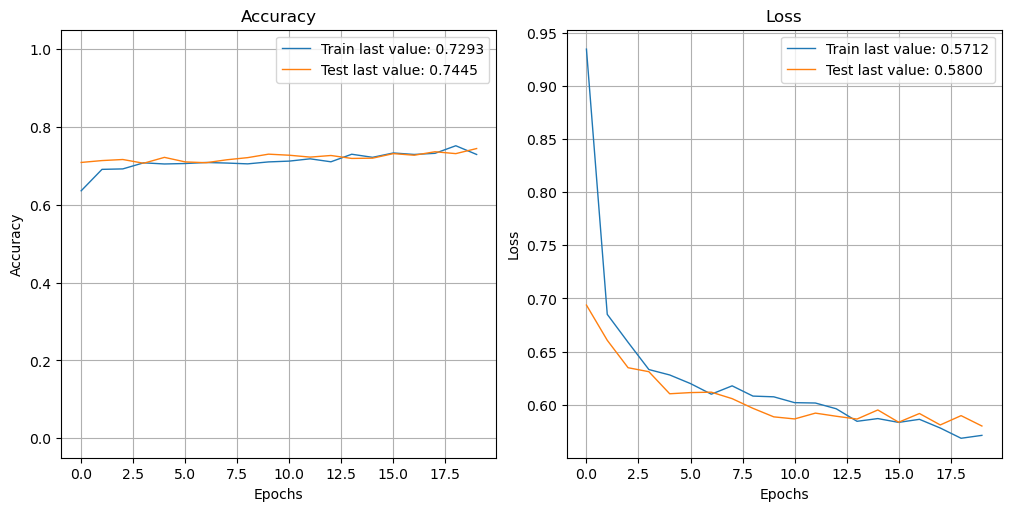

In [44]:
# Plot de l'historique de l'entraînement
plot_history(history_Glove.history)

In [45]:
# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés :")
print(f" - Units dans LSTM : {best_hps_Glove.get('units')}")
print(f" - Lambda de régularisation L2 : {best_hps_Glove.get('l2_lambda')}")
print(f" - Dropout rate : {best_hps_Glove.get('dropout_rate')}")
print(f" - Learning rate : {best_hps_Glove.get('learning_rate')}")

# Construire le meilleur modèle avec les meilleurs hyperparamètres
# Spécifier l'input_shape correspondant à tes données (par exemple `maxlen`)
input_shape = (maxlen,)  # Nombre max de tokens

# "Build" le modèle explicitement avec la taille d'entrée
best_model_Glove.build(input_shape=(None, *input_shape))  # None correspond à la taille du batch

# Affichage du résumé du modèle
best_model_Glove.summary()

Meilleurs hyperparamètres trouvés :
 - Units dans LSTM : 256
 - Lambda de régularisation L2 : 0.000953783127466293
 - Dropout rate : 0.4
 - Learning rate : 0.001338614394601499


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 40, 200)             │       1,194,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,003,349 (15.27 MB)

 Trainable params: 936,449 (3.57 MB)

 Non-trainable params: 1,194,000 (4.55 MB)

 Optimizer params: 1,872,900 (7.14 MB)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


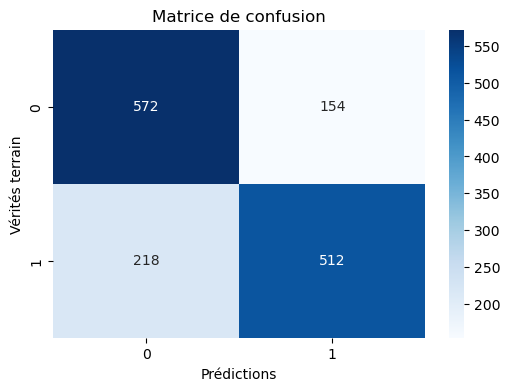

Rapport de classification :
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       726
           1       0.77      0.70      0.73       730

    accuracy                           0.74      1456
   macro avg       0.75      0.74      0.74      1456
weighted avg       0.75      0.74      0.74      1456



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Faire des prédictions sur le jeu de test
y_pred_probs = best_model_Glove.predict(test_padded)  # Prédictions en probabilités
y_pred = (y_pred_probs > 0.5).astype("int32")   # Conversion en classes (0 ou 1)

# 2. Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# 3. Afficher la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


### Log du modèle Glove optimisé dans MLFlow

In [51]:
# Loguer le meilleur modèle et l'historique d'entraînement dans MLflow
with mlflow.start_run(run_name="best_model_Glove"):
    # Loguer les hyperparamètres
    mlflow.log_params(best_hps_Glove.values)
    
    # Loguer le modèle
    mlflow.keras.log_model(best_model_Glove, "model")
    
    # Loguer l'historique d'entraînement (loss, accuracy, etc.)
    for epoch in range(len(history_Glove.history['loss'])):
        mlflow.log_metrics({
            'train_loss': history_Glove.history['loss'][epoch],
            'train_accuracy': history_Glove.history['accuracy'][epoch],
            'val_loss': history_Glove.history['val_loss'][epoch],
            'val_accuracy': history_Glove.history['val_accuracy'][epoch]
        }, step=epoch)
    # Loguer l'image de la matrice de confusion dans MLflow
    mlflow.log_artifact('confusion_matrix.png')
    # Loguer le rapport de classification sous forme de fichier texte
    with open('classification_report.txt', 'w') as f:
        f.write(class_report)    
    # Loguer le rapport de classification dans MLflow
    mlflow.log_artifact('classification_report.txt')

2024/10/18 21:31:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/18 21:31:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/18 21:31:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run best_model_Glove at: http://localhost:5000/#/experiments/566106427225564143/runs/7470f07877ae449fafae586eda5ad831.
2024/10/18 21:31:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/566106427225564143.


# Modèle basé sur Bert (pré-entrainé)

In [ ]:
# pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to preprocess the text and make predictions
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted sentiment label
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map the prediction to the sentiment
    sentiment_labels = ['negative', 'neutral', 'positive']
    return sentiment_labels[predicted_class]

# Example usage
text = "I love using the new RoBERTa model for sentiment analysis!"
sentiment = predict_sentiment(text)
print(f"Sentiment: {sentiment}")


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Load the tokenizer and model from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to predict sentiment
def predict_sentiment_roberta(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Forward pass, get logits
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1)

    return predicted_classes

# Mapping the RoBERTa outputs to your target classes (0 = positive, 1 = negative)
def map_roberta_to_custom_labels(roberta_prediction):
    # RoBERTa has 3 classes: [negative, neutral, positive]
    # We'll map neutral and negative to 'negative' (1), positive to 'positive' (0)
    return 1 if roberta_prediction in [0, 1] else 0

# Process the DataFrame and predict sentiments for train/test data
def process_and_predict(df):
    predicted_labels = []

    for text in df['text']:
        # Predict sentiment for each tweet
        roberta_prediction = predict_sentiment_roberta([text])[0].item()

        # Map RoBERTa sentiment to custom labels
        custom_label = map_roberta_to_custom_labels(roberta_prediction)
        predicted_labels.append(custom_label)

    return predicted_labels

# Predict on training set
train_predictions = process_and_predict(train_df)
train_labels = train_df['target'].tolist()

# Predict on test set
test_predictions = process_and_predict(test_df)
test_labels = test_df['target'].tolist()

# Evaluate the results
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Classification report for further insights
print("\nClassification Report on Train Data:")
print(classification_report(train_labels, train_predictions, target_names=["positive", "negative"]))

print("\nClassification Report on Test Data:")
print(classification_report(test_labels, test_predictions, target_names=["positive", "negative"]))


# Test Roberta tweets sentiment analysis avec fine-tuning

In [ ]:
import torch
print("CUDA disponible:", torch.cuda.is_available())  # Devrait retourner True
print("Nom du GPU:", torch.cuda.get_device_name(0))   # Affiche le nom du GPU
print("Version de PyTorch:", torch.__version__)       # Devrait afficher 2.4.1


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
# Freeze all layers except the last classification layer
for param in model.base_model.parameters():
    param.requires_grad = False

In [ ]:
import torch
from torch.utils.data import Dataset

# Custom Dataset class to handle tokenization
class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        target = self.targets[index]

        # Tokenization
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# # Sous-échantillonage de train_df
# from sklearn.model_selection import train_test_split

# # Taille de l'échantillon (20% du total)
# sample_size = 0.2

# # Création du sous-échantillon avec stratification sur la colonne 'target'
# train_sample, _ = train_test_split(train_df,
#                                    test_size=1 - sample_size,
#                                    stratify=train_df['target'],
#                                    random_state=42)

# # Affichage de la répartition des classes dans le sous-échantillon
# print(train_sample['target'].value_counts(normalize=True))

In [ ]:
# Recap modèle et assignation de device pour le calcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from tweet_dataset import TweetDataset  # Importer la classe depuis le module séparé

# Function to create the DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        texts=df['text'].to_numpy(),
        targets=df['target'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4  # Adjust according to your machine
    )

In [ ]:
# Main execution block
if __name__ == "__main__":
    maxlen = 40  # Max tokens
    batch_size = 16  # Increase to lower calculation time

    # Prepare the data
    train_dataloader = create_data_loader(train_df, tokenizer, maxlen, batch_size)
    test_dataloader = create_data_loader(test_df, tokenizer, maxlen, batch_size)
    # Example usage of DataLoader (test de l'utilisation de la classe tweet_dataset
    # for batch in train_dataloader:
    #     print(batch)
    #     break  # Remove this line to process the full dataset

In [ ]:
from torch.optim import AdamW
# Optimizer and learning rate (adjustable)
optimizer = AdamW(model.parameters(), lr=0.0001)

In [ ]:
# Training function
def train_epoch(model, dataloader, optimizer, device):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        total_correct += torch.sum(preds == targets)
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    return total_correct.double() / total_samples, total_loss / total_samples

# Evaluation function
def eval_model(model, dataloader, device):
    model = model.eval()
    total_correct = 0
    total_samples = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            total_correct += torch.sum(preds == targets)
            total_samples += targets.size(0)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    accuracy = total_correct.double() / total_samples
    return accuracy, predictions, true_labels

In [ ]:
epochs = 20  # Adjust as necessary

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
    print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import recall_score
# import matplotlib.pyplot as plt

# # Function to calculate recall (as a callback metric)
# def calculate_recall(y_true, y_pred):
#     y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
#     y_true = y_true.cpu().numpy()
#     return recall_score(y_true, y_pred, average='macro')

In [ ]:
# # Train and evaluation function
# def train_epoch(model, dataloader, optimizer, device):
#     model.train()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in dataloader:
#         optimizer.zero_grad()
#         inputs = batch['input_ids'].to(device)
#         masks = batch['attention_mask'].to(device)
#         targets = batch['targets'].to(device)

#         outputs = model(input_ids=inputs, attention_mask=masks).logits
#         loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == targets)
#         total_predictions += targets.size(0)

#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses)

# def eval_model(model, dataloader, device):
#     model.eval()
#     losses = []
#     correct_predictions = 0
#     total_predictions = 0
#     recalls = []

#     with torch.no_grad():
#         for batch in dataloader:
#             inputs = batch['input_ids'].to(device)
#             masks = batch['attention_mask'].to(device)
#             targets = batch['targets'].to(device)

#             outputs = model(input_ids=inputs, attention_mask=masks).logits
#             loss = torch.nn.CrossEntropyLoss()(outputs, targets)

#             _, preds = torch.max(outputs, dim=1)
#             correct_predictions += torch.sum(preds == targets)
#             total_predictions += targets.size(0)
            
#             # Recall calculation
#             recalls.append(calculate_recall(targets, outputs))

#             losses.append(loss.item())

#     return correct_predictions.double() / total_predictions, np.mean(losses), np.mean(recalls)

In [ ]:
# # Training loop with callbacks, early stopping and history tracking
# def train_model(model, train_dataloader, test_dataloader, optimizer, epochs, device, patience=3):
#     history = {
#         'train_loss': [],
#         'test_loss': [],
#         'train_recall': [],
#         'test_recall': []
#     }

#     best_recall = 0
#     early_stopping_counter = 0

#     for epoch in range(epochs):
#         # Training
#         train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, device)
#         # Evaluation
#         test_acc, test_loss, test_recall = eval_model(model, test_dataloader, device)
        
#         # Save metrics to history
#         history['train_loss'].append(train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_recall'].append(train_acc)
#         history['test_recall'].append(test_recall)

#         # Print progress
#         print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Recall: {test_recall:.4f}')

#         # Early stopping based on loss improvement
#         if test_recall > best_recall:
#             best_recall = test_recall
#             early_stopping_counter = 0
#             # Optionally save the best model here
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             early_stopping_counter += 1

#         if early_stopping_counter >= patience:
#             print(f"Early stopping after {epoch + 1} epochs")
#             break

#     # Save history to a file
#     with open('history.npy', 'wb') as f:
#         np.save(f, history)

#     # Plot loss and recall
#     plot_history(history)

In [ ]:
# def plot_history(history):
#     epochs = len(history['train_loss'])
#     plt.figure(figsize=(14, 5))

#     # Plot loss
#     plt.subplot(1, 2, 1)
#     plt.plot(range(epochs), history['train_loss'], label='Train Loss')
#     plt.plot(range(epochs), history['test_loss'], label='Test Loss')
#     plt.legend()
#     plt.title('Loss Evolution')
    
#     # Plot recall
#     plt.subplot(1, 2, 2)
#     plt.plot(range(epochs), history['train_recall'], label='Train Recall')
#     plt.plot(range(epochs), history['test_recall'], label='Test Recall')
#     plt.legend()
#     plt.title('Recall Evolution')

#     plt.show()

In [ ]:
# train_model(model, train_dataloader, test_dataloader, optimizer, epochs=5, device=device)

In [ ]:
# Evaluate the model on the test set
test_acc, test_preds, test_true = eval_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Classification report
print("\nClassification Report on Test Data:")
print(classification_report(test_true, test_preds, target_names=["positive", "negative"]))

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()
dt_string = now.strftime("%m_%d_%Y_%H_%M")

# Save the model
model_save_path = f'./models/roberta_fine_tuned_{dt_string}'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")